<h1>2. fáza - predspracovanie dát</h1>

In [507]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import re

In [508]:
def splitPersonalInfo(dataO):
    temp = dataO['personal_info'].str.split("\r\r\n|--|\\|", expand = True)
    dataO['ethn'] = temp[0]
    dataO['state'] = temp[1]
    dataO['edu'] = temp[2]
    dataO['status'] = temp[3]
    dataO['fam_memb'] = temp[4] 
    dataO.drop(['personal_info'], axis = 1, inplace = True)

In [509]:
def fusionDuplicates(datasetO):
    duplicat = datasetO[datasetO['name'].duplicated(keep=False)]
    duplicat = duplicat.sort_values('name')
    duplicat = duplicat.reset_index(drop=True)
    
    for i, row in duplicat.iterrows():
        if(i%2==1):
            duplicat = duplicat.drop(i)
            continue
        for j, value in row.items():
            dupValue = duplicat.loc[i+1,j]
            if(pd.isna(value)):
                duplicat.loc[i,j]=dupValue
    datasetO.drop_duplicates(subset='name',keep=False,inplace=True)
    result = datasetO.append(duplicat, ignore_index=True)
    return(result)

In [510]:
def correctValuesO(dataset):
    for col in dataset.columns:
        if(dataset[col].dtype != np.object):
           continue
        dataset[col] = dataset[col].str.replace('_','-')
        dataset[col] = dataset[col].replace(to_replace = r'.*\?.*', value = np.nan, regex = True)
        dataset[col] = dataset[col].replace(to_replace = r'^[Nn][Aa][Nn]$', value = np.nan, regex = True)
        if(col=='pregnant'):
            dataset[col] = dataset[col].replace(['T','F'], ['t', 'f'])
            dataset[col] = dataset[col].replace(to_replace = r'[Tt][Rr][Uu][Ee]', value = 't', regex = True)
            dataset[col] = dataset[col].replace(to_replace = r'[Ff][Aa][Ll][Ss][Ee]', value = 'f', regex = True)

def correctDates(series):
    s = series.str.split("-", expand = True)
    x = 0
    while(x<len(series)):
#        print(str(x)+" "+s.iloc[x])
        if(re.match(r'^[0-9][0-9]-[0-9][0-9]-[0-9][0-9]$', series.loc[x])):
            if(s.iloc[x][0][:1]=='0'):
                series.loc[x] = "20"+s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][0:2]
            else:
                series.loc[x] = "19"+s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][0:2]
#            x += 1
#            continue
         #if(len(s.iloc[x][2])>2):
         #   series.loc[x] = s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][:2]
        if(re.match(r'^[0-9][0-9]-[0-9][0-9]-[0-9][0-9][0-9][0-9]$', series.loc[x])):
            y = s.iloc[x][0]
            s.iloc[x][0] = s.iloc[x][2]
            s.iloc[x][2] = y
            series.loc[x] = s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][0:2]
        if(len(series.loc[x])>10):
            series.loc[x] = series.loc[x][0:10]
        x += 1
        
def correctValuesP(dataset):
    for col in dataset.columns:
        if(dataset[col].dtype != np.object):
           continue
        dataset[col] = dataset[col].str.replace('/','-')    
    correctDates(dataset["date_of_birth"])
        

In [511]:

def fusionDatasets(dataset1, dataset2):
    newDS = dataset1.merge(dataset2, on='name')
    newDS = newDS.drop(columns=['name', 'address_x', 'address_y'])
    return newDS

In [512]:
def correctAge(dataF):
    x = 0
    for x in range(len(dataF)):
        print(x)
        s = dataF['date_of_birth'].iloc[x].split('-', 2)
        year = s[0]
        #116 najstarsi clovek v sucastnosti
        if(dataF['age'].iloc[x]>116):
            age = dataF['age'].iloc[x]/100
            if((2019-int(age) == int(year) or (2019-int(age) == int(year)+1))):
               dataF['age'].iloc[x] =  int(age);
               continue
            else:
                print("ERROR  "+str(age)+"  "+str(int(year)))
        elif(dataF['age'].iloc[x]<-116):
            age = dataF['age'].iloc[x]/(-100)
            if(2019-int(age) == int(year) or 2019-int(age) == int(year)+1):
               dataF['age'].iloc[x] =  int(age);
               continue
            else:
                print("ERROR  "+str(age)+"  "+str(int(year)))
        else:
            age = 2019 - int(year)
            if(age<=0):
                dataF['age'].iloc[x] = np.nan
            else:
                dataF['age'].iloc[x] =  int(age);
            

In [564]:
percentil5 = []
percentil95 = []

In [565]:
def detectReplaceOutliers(dataF):
    for col in dataF.columns:
        if(dataF[col].dtype == np.object):
           continue
        if(col == 'capital-loss' or col == 'capital-gain' or col == 'age'):
           continue
        percentil5.append(dataF[col].quantile(0.05))
        percentil95.append(dataF[col].quantile(0.95))
        p5 = percentil5[-1]
        p95 = percentil95[-1]
        print(p5)
        print(p95)
        dataF.loc[:,col] = dataF[col].apply(lambda x: p5 if x<p5 else x)
        dataF.loc[:,col] = dataF[col].apply(lambda x: p95 if x>p95 else x)

In [514]:
dataP = pd.read_csv("personal_train.csv", index_col=0)
dataO = pd.read_csv("other_train.csv", index_col=0)

In [515]:
splitPersonalInfo(dataO)

In [516]:
dataP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 5 columns):
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(1), object(4)
memory usage: 184.4+ KB


In [517]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 25 columns):
name                3983 non-null object
address             3983 non-null object
kurtosis_oxygen     3709 non-null object
occupation          3974 non-null object
pregnant            3967 non-null object
education-num       3964 non-null float64
skewness_glucose    3970 non-null float64
mean_glucose        3573 non-null float64
std_oxygen          3967 non-null float64
capital-gain        3970 non-null float64
skewness_oxygen     3969 non-null float64
kurtosis_glucose    3965 non-null float64
fnlwgt              3974 non-null float64
class               3972 non-null float64
std_glucose         3964 non-null float64
income              3967 non-null object
mean_oxygen         3971 non-null float64
hours-per-week      3969 non-null float64
capital-loss        3971 non-null float64
workclass           3961 non-null object
ethn                3968 non-null object
state              

In [518]:
len(dataO.name.unique())

3933

In [519]:
namesO = dataO["name"].unique().sort()

In [520]:
namesP = dataP["name"].unique().sort()

In [521]:
np.array_equal(namesO, namesP)

True

In [522]:
dataO.head()

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",10.58036423,Sales,f,9.0,3.158830,85.859375,14.121127,0.0,...,>50K,1.857860,40.0,1902.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",3.713364594,Craft-repair,f,9.0,1.234184,91.679688,36.946291,0.0,...,<=50K,10.001672,40.0,2002.0,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",6.478064004,Handlers-cleaners,f,9.0,1.872355,89.960938,22.646980,0.0,...,<=50K,4.134615,48.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,10.0,0.395583,NaN,14.001759,0.0,...,>50K,1.849498,40.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,9.0,0.493384,94.593750,29.361953,0.0,...,<=50K,5.739130,40.0,0.0,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband


In [523]:
duplNames = dataO[dataO['name'].duplicated(keep=False)]
duplNames.sort_values('name')

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
3718,Andrew Lawson,57159 Christopher Throughway Apt. 388\r\nWest ...,10.56049223,NaN,f,NaN,2.486716,87.585938,16.756233,0.0,...,>50K,2.035117,40.0,0.0,NaN,White,United-States,Bachelors,Married-civ-spouse,Husband
1298,Andrew Lawson,57159 Christopher Throughway Apt. 388\r\nWest ...,10.56049223,Sales,f,13.0,2.486716,87.585938,16.756233,NaN,...,NaN,2.035117,40.0,0.0,Private,White,United-States,Bachelors,Married-civ-spouse,Husband
3402,Andrew Olmstead,"519 Christopher Loop Suite 282\r\nRachelside, ...",6.9289193560000015,Craft-repair,f,9.0,0.548669,NaN,26.559749,0.0,...,<=50K,4.382943,52.0,0.0,NaN,White,United-States,HS-grad,Married-civ-spouse,Husband
281,Andrew Olmstead,"519 Christopher Loop Suite 282\r\nRachelside, ...",6.9289193560000015,NaN,f,NaN,0.548669,NaN,26.559749,0.0,...,<=50K,4.382943,52.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3851,Antonio Bailey,"29028 Bowman Parkways\r\nKerrview, FL 57851",0.368701087,Sales,f,6.0,10.093518,57.312500,79.734804,0.0,...,<=50K,96.128763,40.0,NaN,Self-emp-inc,White,Canada,10th,Widowed,Unmarried
2222,Antonio Bailey,"29028 Bowman Parkways\r\nKerrview, FL 57851",0.368701087,Sales,NaN,NaN,10.093518,57.312500,79.734804,NaN,...,<=50K,NaN,40.0,0.0,Self-emp-inc,White,Canada,10th,Widowed,Unmarried
2606,Antonio Rowan,"016 Jacob Tunnel Apt. 031\r\nAmandabury, CA 37683",??,Handlers-cleaners,f,9.0,0.208850,128.968750,15.056887,0.0,...,NaN,1.887960,45.0,0.0,Private,NaN,NaN,NaN,NaN,NaN
1987,Antonio Rowan,"016 Jacob Tunnel Apt. 031\r\nAmandabury, CA 37683",??,Handlers-cleaners,NaN,9.0,0.208850,128.968750,15.056887,0.0,...,<=50K,1.887960,45.0,0.0,Private,Black,United-States,HS-grad,Separated,Unmarried
3947,Ben Nelson,"45315 Obrien Inlet\r\nCynthiaport, OH 63603",22.14937084,Transport-moving,f,9.0,1.137467,92.804688,9.089983,0.0,...,>50K,0.511706,40.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
956,Ben Nelson,"45315 Obrien Inlet\r\nCynthiaport, OH 63603",22.14937084,Transport-moving,f,9.0,NaN,NaN,NaN,0.0,...,>50K,0.511706,40.0,0.0,Private,NaN,NaN,NaN,NaN,NaN


Po vypísani duplicitných mien sme zistili, že zlúčením týchto duplikátov vieme vyplniť chýbajúce hodnoty. Zároveň hodnoty, ktoré majú oba duplikáty sú rovnaké. 

In [524]:
dataO=fusionDuplicates(dataO)
dataO

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",10.58036423,Sales,f,9.0,3.158830,85.859375,14.121127,0.0,...,>50K,1.857860,40.0,1902.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",3.713364594,Craft-repair,f,9.0,1.234184,91.679688,36.946291,0.0,...,<=50K,10.001672,40.0,2002.0,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",6.478064004,Handlers-cleaners,f,9.0,1.872355,89.960938,22.646980,0.0,...,<=50K,4.134615,48.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,10.0,0.395583,NaN,14.001759,0.0,...,>50K,1.849498,40.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,9.0,0.493384,94.593750,29.361953,0.0,...,<=50K,5.739130,40.0,0.0,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
5,Todd Flanagan,"2167 Wells Shoals Apt. 264\r\nEast Brianshire,...",6.384963147000001,?,f,9.0,-0.303185,125.742188,29.664529,0.0,...,<=50K,4.951505,15.0,0.0,?,White,United-States,HS-grad,Married-civ-spouse,Own-child
6,James Huffman,"535 Michael Squares\r\nNorth Sara, ID 61368",8.938092965,Sales,f,10.0,0.091356,145.835938,19.440728,0.0,...,<=50K,2.637124,50.0,0.0,Private,White,United-States,Some-college,Divorced,Not-in-family
7,Gary Prentice,"055 Nolan Club\r\nWest Bryanton, UT 15308",5.155939859,?,f,12.0,0.046797,138.179688,31.576347,0.0,...,<=50K,6.330268,1.0,0.0,?,White,United-States,Assoc-acdm,Divorced,Unmarried
8,Rodger Riis,7719 Frances Drives Apt. 525\r\nWest Brandonst...,2.436555082,Sales,f,10.0,-0.797075,129.976562,56.661158,0.0,...,<=50K,22.038462,35.0,0.0,Self-emp-inc,White,United-States,Some-college,Never-married,Own-child
9,Robert Cabiness,"70838 Robbins Camp Suite 853\r\nJacobville, SC...",14.38934822,Sales,f,9.0,1.035747,107.578125,11.797305,0.0,...,<=50K,1.002508,40.0,0.0,Private,White,United-States,HS-grad,Never-married,Own-child


In [525]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 25 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3677 non-null object
occupation          3933 non-null object
pregnant            3933 non-null object
education-num       3933 non-null float64
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3931 non-null object
ethn                3932 non-null object
state              

In [526]:
replaced = dataO.replace(to_replace=r'^[0-9,\-].*[0-9]$',value='number',regex=True)
replaced.select_dtypes(include='object')

,name,address,kurtosis_oxygen,occupation,pregnant,income,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",number,Sales,f,>50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",number,Craft-repair,f,<=50K,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",number,Handlers-cleaners,f,<=50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,>50K,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,<=50K,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
5,Todd Flanagan,"2167 Wells Shoals Apt. 264\r\nEast Brianshire,...",number,?,f,<=50K,?,White,United-States,HS-grad,Married-civ-spouse,Own-child
6,James Huffman,"535 Michael Squares\r\nNorth Sara, ID 61368",number,Sales,f,<=50K,Private,White,United-States,Some-college,Divorced,Not-in-family
7,Gary Prentice,"055 Nolan Club\r\nWest Bryanton, UT 15308",number,?,f,<=50K,?,White,United-States,Assoc-acdm,Divorced,Unmarried
8,Rodger Riis,7719 Frances Drives Apt. 525\r\nWest Brandonst...,number,Sales,f,<=50K,Self-emp-inc,White,United-States,Some-college,Never-married,Own-child
9,Robert Cabiness,"70838 Robbins Camp Suite 853\r\nJacobville, SC...",number,Sales,f,<=50K,Private,White,United-States,HS-grad,Never-married,Own-child


In [527]:
replaced['kurtosis_oxygen'].unique()

array(['number', '??', nan], dtype=object)

In [528]:
replaced['occupation'].unique()

array([' Sales', ' Craft-repair', ' Handlers-cleaners',
       ' Transport-moving', ' ?', ' Adm-clerical', ' Exec-managerial',
       ' Farming-fishing', ' Other-service', ' Prof-specialty',
       ' Tech-support', ' Machine-op-inspct', ' Exec_managerial',
       ' Other_service', ' Prof_specialty', ' Protective-serv',
       ' Craft_repair', ' Protective_serv', ' Adm_clerical',
       ' Machine_op_inspct', ' Farming_fishing', ' Priv-house-serv',
       ' Transport_moving', ' Handlers_cleaners', ' Priv_house_serv',
       ' Tech_support', ' Armed-Forces'], dtype=object)

In [529]:
replaced['pregnant'].unique()

array(['f', 'F', 'FALSE', 't', 'TRUE', 'T'], dtype=object)

In [530]:
replaced['education-num'].unique()

array([ 9., 10., 12., 13.,  7., 11., 14., 16.,  8.,  6.,  3., 15.,  4.,
        5.,  2.,  1.])

In [531]:
replaced['edu'].unique()

array(['HS-grad ', 'Some-college ', 'Assoc-acdm ', 'Bachelors ', '11th ',
       'Assoc-voc ', 'Masters ', 'Doctorate ', '12th ', '10th ',
       '5th-6th ', 'Prof-school ', '7th-8th ', '9th ', '1st-4th ',
       'Preschool ', nan], dtype=object)

In [532]:
replaced['income'].unique()

array([' >50K', ' <=50K', nan], dtype=object)

In [533]:
replaced['workclass'].unique()

array([' Private', ' Self-emp-not-inc', ' ?', ' Self-emp-inc',
       ' Federal-gov', ' State-gov', ' Local-gov', ' Without-pay', nan],
      dtype=object)

In [534]:
replaced['ethn'].unique()

array(['White', 'Amer-Indian-Eskimo', 'Black', 'Asian-Pac-Islander',
       'Other', nan], dtype=object)

In [535]:
replaced['state'].unique()

array(['United-States', 'India', 'Thailand', 'Puerto-Rico', 'Philippines',
       'Cuba', '?', 'China', 'Columbia', 'Canada', 'Poland', 'Mexico',
       'Vietnam', 'El-Salvador', 'Jamaica', 'Japan', 'Yugoslavia',
       'Italy', 'Germany', 'Guatemala', 'Ecuador', 'Hungary', 'Ireland',
       'Taiwan', 'England', 'France', 'Peru', 'Portugal', 'South',
       'Trinadad&Tobago', 'Dominican-Republic', 'Iran', 'Cambodia',
       'Outlying-US(Guam-USVI-etc)', 'Haiti', 'Scotland', 'Nicaragua',
       'Hong', 'Holand-Netherlands', 'Greece', nan], dtype=object)

In [536]:
replaced['status'].unique()

array([' Married-civ-spouse', ' Divorced', ' Never-married', ' Separated',
       ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse', nan],
      dtype=object)

In [537]:
replaced['fam_memb'].unique()

array(['Husband', 'Own-child', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative', nan], dtype=object)

In [538]:
correctValuesO(dataO)

In [539]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 25 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3539 non-null object
occupation          3733 non-null object
pregnant            3933 non-null object
education-num       3933 non-null float64
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3731 non-null object
ethn                3932 non-null object
state              

In [540]:
dataO['pregnant'].unique()

array(['f', 't'], dtype=object)

In [541]:
replaced = dataP.replace(to_replace = r'[0-9]', value = 'x', regex = True)

In [542]:
replaced["date_of_birth"].unique()

array(['xxxx-xx-xx', 'xx-xx-xx', 'xx/xx/xxxx', 'xxxx-xx-xx xx:xx:xx',
       'xxxx-xx-xx xx xx xx', 'xxxx/xx/xx'], dtype=object)

xx/xx/xxxx --> dd/mm/yyyy

In [543]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9]/[0-9][0-9]/[0-9][0-9][0-9][0-9]')].sort_values(ascending=False).str.split("/", 3, expand = True)

In [544]:
date.max()

0      31.0
1      12.0
2    2005.0
dtype: float64

xxxx/xx/xx --> yyyy/mm/dd

In [545]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9][0-9][0-9]/[0-9][0-9]/[0-9][0-9]')].sort_values(ascending=False).str.split("/", 3, expand = True)

In [546]:
date.max()

0    2020.0
1      12.0
2      31.0
dtype: float64

xxxx-xx-xx --> yyyy-mm-dd

In [547]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]')].sort_values(ascending=False).str.split("-", 3, expand = True)

In [548]:
date.max()

0           2016
1             12
2    31 00:00:00
dtype: object

xx-xx-xx --> yy-mm-dd

In [549]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9]-[0-9][0-9]-[0-9][0-9]')].sort_values(ascending=False).str.split("-", 3, expand = True)

In [550]:
date.max()

0    96.0
1    12.0
2    31.0
dtype: float64

In [551]:
date[0].unique()

array(['96', '93', '91', '90', '89', '88', '87', '86', '85', '84', '83',
       '82', '81', '80', '79', '78', '77', '76', '75', '74', '73', '72',
       '71', '70', '69', '68', '67', '66', '65', '64', '63', '62', '61',
       '60', '59', '58', '57', '56', '55', '54', '53', '52', '51', '50',
       '49', '48', '47', '42', '39', '29', '03', '00'], dtype=object)

In [552]:
correctValuesP(dataP)

C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [553]:
replaced = dataP.replace(to_replace = r'[0-9]', value = 'x', regex = True)
replaced['date_of_birth'].unique()

array(['xxxx-xx-xx'], dtype=object)

In [554]:
dataF = fusionDatasets(dataP, dataO)

In [555]:
dataF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null int64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3539 non-null object
occupation          3733 non-null object
pregnant            3933 non-null object
education-num       3933 non-null float64
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3731 non-null object
ethn                

In [556]:
dataF = dataF.astype({'class':str,"education-num":str})
replaced = dataF.replace(to_replace=r'^[0-9]*\.[0-9]*$',value='number',regex=True)
dataF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null int64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3539 non-null object
occupation          3733 non-null object
pregnant            3933 non-null object
education-num       3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null object
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3731 non-null object
ethn                39

In [557]:
dataF['age'].quantile(0.05)

13.200000000000045

In [558]:
correctAge(dataF)

0
1
2


C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083


In [559]:
dataF['age'].unique()

array([ 36.,  48.,  62.,  17.,  35.,  60.,  49.,  43.,  41.,  58.,  56.,
        50.,  42.,  67.,  52.,  68.,  65.,  77.,  66.,  27.,  59.,  64.,
        63.,  57.,  71.,  31.,  61.,  51.,  40.,  46.,  38.,  55.,  47.,
        70.,  69.,  37.,  34.,  45.,  44.,  28.,  53.,  75.,  54.,  26.,
        39.,  30.,  32.,  74.,  25.,  72.,  29.,  82.,  73.,  80.,  84.,
        33.,  23.,  24.,  20.,  76.,  83.,  79.,  14.,  81.,  22.,  85.,
        90.,  21.,  78.,   3.,  16.,  94.,  18.,  19.,  nan,  87.,  86.,
       113.,  97.,   9.,   8.,  12.,  99.,  15.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B39A51EC88>,
      dtype=object)

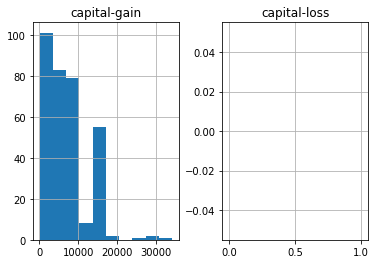

In [569]:
replaced = dataF[['capital-gain', 'capital-loss']].replace(to_replace=[0.0,99999.0],value = np.nan)
replaced.hist()

Pre tieto dva stlpce nebudeme odstranovat outlierov pretoze by sme prisli o tieto namerane hodnoty. 

In [567]:
detectReplaceOutliers(dataF)

-0.5264023059999999
28.813319694
27.458593750000002
140.671875
11.333620886
77.80748361799998
-0.8705938258
277.16984213999996
-0.19271794260000003
5.028178363399996
41468.600000000006
370317.3999999998
31.172278147
56.186057243
1.0583612036
107.68979933999981
17.0
60.0
0.0
0.0


In [568]:
dataF.describe()

,age,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,std_glucose,mean_oxygen,hours-per-week,capital-loss
count,3932.000000,3933.000000,3539.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3932.000000,3933.000000,3932.000000,3933.0
mean,51.998474,3.752209,101.391740,30.818246,1174.541571,83.867000,0.915734,185183.389016,45.046878,17.018350,40.398525,0.0
std,11.780274,7.913378,31.688818,21.234781,7963.624523,79.241345,1.463956,87777.119075,6.974492,29.561269,10.393927,0.0
min,3.000000,-0.526402,27.458594,11.333621,0.000000,-0.870594,-0.192718,41468.600000,31.172278,1.058361,17.000000,0.0
25%,45.000000,-0.119966,87.789062,15.040684,0.000000,12.866679,0.072144,118717.000000,40.164837,2.065217,40.000000,0.0
50%,52.000000,0.373828,110.539062,20.567593,0.000000,68.490474,0.310784,180599.000000,45.887636,3.236622,40.000000,0.0
75%,60.000000,2.081514,124.121094,43.221350,0.000000,127.012005,0.776762,235847.000000,50.369084,12.631271,45.000000,0.0
max,113.000000,28.813320,140.671875,77.807484,99999.000000,277.169842,5.028178,370317.400000,56.186057,107.689799,60.000000,0.0
